In [2]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [4]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        self.y_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
#         dX = dout @ W.T # vanilla Backprop
        dX = dout @ W_fixed.T # fba backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
#         y, nl_cache = l.sigmoid_forward(X=y) # non-linearity/ activation
#         y -= l.sigmoid(0.0) # zero-centered/ mean
#         y *= 2.0 # uni-var/ std
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
#             y, nl_cache = l.sigmoid_forward(X=y) # non-linearity/ activation
#             y -= l.sigmoid(0.0) # zero-centered/ mean
#             y *= 2.0 # uni-var/ std
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches, y):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
#         dy_prev = self.dy_prev.copy() # for temporal differencing
#         self.dy_prev = dy.copy() # next iteration/ epoch
        y_prev = self.y_prev.copy() # for temporal differencing
        self.y_prev = y.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward is included in dcross_entropy.
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
# #         dy =  dy @ self.W_fixed[2].T # done
#         dy_prev =  dy_prev @ self.W_fixed[2].T
        y =  y @ self.W_fixed[2].T # done
        y_prev =  y_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
#             dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy *= dy - dy_prev # temporal diff instead of differentiable function
            dy *= y - y_prev # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
# #             dy =  dy @ self.W_fixed[2].T # done
#             dy_prev =  dy_prev @ self.W_fixed[1][layer].T
            y =  y @ self.W_fixed[1][layer].T # done
            y_prev =  y_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
#         dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
#         dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#         dy *= dy - dy_prev # temporal diff instead of differentiable function
        dy *= y - y_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            _, grads = self.train_backward(dy, caches, y_prob)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
#             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
#             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [5]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-2.3043, acc-0.1200, valid loss-2.2970, acc-0.0914, test loss-2.2932, acc-0.1012
Iter-20, train loss-2.2754, acc-0.1400, valid loss-2.2969, acc-0.0916, test loss-2.2931, acc-0.1011
Iter-30, train loss-2.2841, acc-0.1000, valid loss-2.2968, acc-0.0918, test loss-2.2930, acc-0.1015
Iter-40, train loss-2.2906, acc-0.1000, valid loss-2.2967, acc-0.0918, test loss-2.2929, acc-0.1014
Iter-50, train loss-2.2893, acc-0.1000, valid loss-2.2966, acc-0.0920, test loss-2.2928, acc-0.1016
Iter-60, train loss-2.3083, acc-0.0400, valid loss-2.2965, acc-0.0918, test loss-2.2927, acc-0.1017
Iter-70, train loss-2.3308, acc-0.0200, valid loss-2.2964, acc-0.0920, test loss-2.2925, acc-0.1017
Iter-80, train loss-2.3082, acc-0.1600, valid loss-2.2963, acc-0.0928, test loss-2.2924, acc-0.1024
Iter-90, train loss-2.2969, acc-0.1200, valid loss-2.2962, acc-0.0928, test loss-2.2923, acc-0.1023
Iter-100, train loss-2.2948, acc-0.1000, valid loss-2.2961, acc-0.0936, test loss-2.2922, acc-0.1028

Iter-830, train loss-2.2949, acc-0.0200, valid loss-2.2886, acc-0.1204, test loss-2.2847, acc-0.1276
Iter-840, train loss-2.2745, acc-0.2200, valid loss-2.2885, acc-0.1208, test loss-2.2846, acc-0.1284
Iter-850, train loss-2.2687, acc-0.2200, valid loss-2.2884, acc-0.1210, test loss-2.2845, acc-0.1289
Iter-860, train loss-2.2853, acc-0.1600, valid loss-2.2883, acc-0.1212, test loss-2.2844, acc-0.1292
Iter-870, train loss-2.2625, acc-0.1600, valid loss-2.2882, acc-0.1212, test loss-2.2843, acc-0.1296
Iter-880, train loss-2.2836, acc-0.0600, valid loss-2.2881, acc-0.1212, test loss-2.2842, acc-0.1298
Iter-890, train loss-2.2937, acc-0.0600, valid loss-2.2880, acc-0.1212, test loss-2.2841, acc-0.1305
Iter-900, train loss-2.3065, acc-0.0400, valid loss-2.2879, acc-0.1220, test loss-2.2840, acc-0.1313
Iter-910, train loss-2.2982, acc-0.0800, valid loss-2.2878, acc-0.1222, test loss-2.2839, acc-0.1319
Iter-920, train loss-2.3016, acc-0.1200, valid loss-2.2877, acc-0.1228, test loss-2.2838, a

Iter-1640, train loss-2.2617, acc-0.1600, valid loss-2.2804, acc-0.1520, test loss-2.2764, acc-0.1621
Iter-1650, train loss-2.2809, acc-0.1800, valid loss-2.2803, acc-0.1526, test loss-2.2763, acc-0.1630
Iter-1660, train loss-2.2884, acc-0.0600, valid loss-2.2802, acc-0.1532, test loss-2.2762, acc-0.1632
Iter-1670, train loss-2.2774, acc-0.1800, valid loss-2.2801, acc-0.1536, test loss-2.2761, acc-0.1637
Iter-1680, train loss-2.2728, acc-0.1800, valid loss-2.2800, acc-0.1538, test loss-2.2760, acc-0.1639
Iter-1690, train loss-2.2804, acc-0.1200, valid loss-2.2799, acc-0.1540, test loss-2.2759, acc-0.1643
Iter-1700, train loss-2.3002, acc-0.1800, valid loss-2.2798, acc-0.1552, test loss-2.2758, acc-0.1649
Iter-1710, train loss-2.2755, acc-0.1800, valid loss-2.2797, acc-0.1554, test loss-2.2757, acc-0.1649
Iter-1720, train loss-2.2714, acc-0.1400, valid loss-2.2796, acc-0.1552, test loss-2.2756, acc-0.1651
Iter-1730, train loss-2.3027, acc-0.1200, valid loss-2.2795, acc-0.1554, test loss

Iter-2450, train loss-2.2418, acc-0.3000, valid loss-2.2722, acc-0.1714, test loss-2.2682, acc-0.1871
Iter-2460, train loss-2.2758, acc-0.1400, valid loss-2.2721, acc-0.1722, test loss-2.2681, acc-0.1875
Iter-2470, train loss-2.2384, acc-0.1600, valid loss-2.2720, acc-0.1718, test loss-2.2680, acc-0.1880
Iter-2480, train loss-2.2528, acc-0.3200, valid loss-2.2719, acc-0.1718, test loss-2.2679, acc-0.1883
Iter-2490, train loss-2.2556, acc-0.3000, valid loss-2.2718, acc-0.1722, test loss-2.2678, acc-0.1884
Iter-2500, train loss-2.2877, acc-0.1400, valid loss-2.2717, acc-0.1724, test loss-2.2677, acc-0.1890
Iter-2510, train loss-2.2711, acc-0.2000, valid loss-2.2716, acc-0.1730, test loss-2.2676, acc-0.1895
Iter-2520, train loss-2.2327, acc-0.3000, valid loss-2.2715, acc-0.1724, test loss-2.2675, acc-0.1893
Iter-2530, train loss-2.2800, acc-0.1800, valid loss-2.2714, acc-0.1728, test loss-2.2674, acc-0.1901
Iter-2540, train loss-2.2864, acc-0.1200, valid loss-2.2713, acc-0.1728, test loss

Iter-3260, train loss-2.2434, acc-0.2200, valid loss-2.2643, acc-0.1832, test loss-2.2602, acc-0.2004
Iter-3270, train loss-2.2597, acc-0.2200, valid loss-2.2642, acc-0.1834, test loss-2.2601, acc-0.2007
Iter-3280, train loss-2.2748, acc-0.2200, valid loss-2.2641, acc-0.1832, test loss-2.2600, acc-0.2008
Iter-3290, train loss-2.2645, acc-0.2800, valid loss-2.2640, acc-0.1832, test loss-2.2599, acc-0.2008
Iter-3300, train loss-2.2600, acc-0.2400, valid loss-2.2639, acc-0.1828, test loss-2.2598, acc-0.2009
Iter-3310, train loss-2.2299, acc-0.2800, valid loss-2.2638, acc-0.1828, test loss-2.2597, acc-0.2013
Iter-3320, train loss-2.2537, acc-0.1800, valid loss-2.2637, acc-0.1834, test loss-2.2596, acc-0.2015
Iter-3330, train loss-2.2772, acc-0.1200, valid loss-2.2636, acc-0.1834, test loss-2.2595, acc-0.2012
Iter-3340, train loss-2.3140, acc-0.1400, valid loss-2.2635, acc-0.1830, test loss-2.2594, acc-0.2015
Iter-3350, train loss-2.2421, acc-0.2200, valid loss-2.2634, acc-0.1830, test loss

Iter-4070, train loss-2.2081, acc-0.3600, valid loss-2.2564, acc-0.1890, test loss-2.2523, acc-0.2071
Iter-4080, train loss-2.2504, acc-0.2000, valid loss-2.2563, acc-0.1890, test loss-2.2522, acc-0.2072
Iter-4090, train loss-2.2690, acc-0.2800, valid loss-2.2562, acc-0.1896, test loss-2.2521, acc-0.2072
Iter-4100, train loss-2.2569, acc-0.1600, valid loss-2.2561, acc-0.1898, test loss-2.2520, acc-0.2074
Iter-4110, train loss-2.2458, acc-0.2000, valid loss-2.2560, acc-0.1896, test loss-2.2519, acc-0.2077
Iter-4120, train loss-2.2454, acc-0.2000, valid loss-2.2559, acc-0.1896, test loss-2.2518, acc-0.2077
Iter-4130, train loss-2.2683, acc-0.2600, valid loss-2.2558, acc-0.1900, test loss-2.2517, acc-0.2077
Iter-4140, train loss-2.2447, acc-0.2200, valid loss-2.2557, acc-0.1900, test loss-2.2516, acc-0.2078
Iter-4150, train loss-2.2740, acc-0.2600, valid loss-2.2556, acc-0.1898, test loss-2.2515, acc-0.2079
Iter-4160, train loss-2.2348, acc-0.2400, valid loss-2.2555, acc-0.1898, test loss

Iter-4880, train loss-2.2658, acc-0.1800, valid loss-2.2487, acc-0.1976, test loss-2.2445, acc-0.2121
Iter-4890, train loss-2.2490, acc-0.2000, valid loss-2.2485, acc-0.1974, test loss-2.2444, acc-0.2122
Iter-4900, train loss-2.2486, acc-0.1400, valid loss-2.2485, acc-0.1974, test loss-2.2443, acc-0.2122
Iter-4910, train loss-2.2426, acc-0.3000, valid loss-2.2484, acc-0.1974, test loss-2.2442, acc-0.2122
Iter-4920, train loss-2.2405, acc-0.2000, valid loss-2.2483, acc-0.1974, test loss-2.2441, acc-0.2120
Iter-4930, train loss-2.2479, acc-0.2400, valid loss-2.2482, acc-0.1976, test loss-2.2440, acc-0.2121
Iter-4940, train loss-2.2251, acc-0.3200, valid loss-2.2481, acc-0.1976, test loss-2.2439, acc-0.2122
Iter-4950, train loss-2.2680, acc-0.1400, valid loss-2.2480, acc-0.1976, test loss-2.2438, acc-0.2120
Iter-4960, train loss-2.2378, acc-0.2400, valid loss-2.2479, acc-0.1982, test loss-2.2437, acc-0.2124
Iter-4970, train loss-2.2272, acc-0.3000, valid loss-2.2478, acc-0.1982, test loss

Iter-5690, train loss-2.2570, acc-0.2400, valid loss-2.2409, acc-0.2056, test loss-2.2367, acc-0.2163
Iter-5700, train loss-2.2167, acc-0.2400, valid loss-2.2408, acc-0.2060, test loss-2.2366, acc-0.2165
Iter-5710, train loss-2.2627, acc-0.1800, valid loss-2.2407, acc-0.2062, test loss-2.2365, acc-0.2169
Iter-5720, train loss-2.2509, acc-0.2400, valid loss-2.2406, acc-0.2064, test loss-2.2364, acc-0.2168
Iter-5730, train loss-2.2522, acc-0.1800, valid loss-2.2405, acc-0.2064, test loss-2.2363, acc-0.2172
Iter-5740, train loss-2.1973, acc-0.2800, valid loss-2.2404, acc-0.2062, test loss-2.2362, acc-0.2172
Iter-5750, train loss-2.2324, acc-0.2600, valid loss-2.2403, acc-0.2060, test loss-2.2361, acc-0.2172
Iter-5760, train loss-2.2369, acc-0.2000, valid loss-2.2402, acc-0.2058, test loss-2.2360, acc-0.2173
Iter-5770, train loss-2.2564, acc-0.1800, valid loss-2.2402, acc-0.2058, test loss-2.2359, acc-0.2176
Iter-5780, train loss-2.2093, acc-0.2600, valid loss-2.2401, acc-0.2058, test loss

Iter-6500, train loss-2.2326, acc-0.1400, valid loss-2.2334, acc-0.2132, test loss-2.2291, acc-0.2250
Iter-6510, train loss-2.2363, acc-0.1000, valid loss-2.2333, acc-0.2132, test loss-2.2290, acc-0.2251
Iter-6520, train loss-2.2440, acc-0.1800, valid loss-2.2332, acc-0.2134, test loss-2.2289, acc-0.2252
Iter-6530, train loss-2.1943, acc-0.2400, valid loss-2.2331, acc-0.2136, test loss-2.2288, acc-0.2254
Iter-6540, train loss-2.2278, acc-0.2000, valid loss-2.2330, acc-0.2136, test loss-2.2287, acc-0.2255
Iter-6550, train loss-2.2344, acc-0.2800, valid loss-2.2329, acc-0.2136, test loss-2.2287, acc-0.2259
Iter-6560, train loss-2.2183, acc-0.1800, valid loss-2.2328, acc-0.2144, test loss-2.2286, acc-0.2260
Iter-6570, train loss-2.2449, acc-0.2400, valid loss-2.2327, acc-0.2146, test loss-2.2285, acc-0.2262
Iter-6580, train loss-2.2270, acc-0.2600, valid loss-2.2326, acc-0.2144, test loss-2.2284, acc-0.2261
Iter-6590, train loss-2.2366, acc-0.1800, valid loss-2.2325, acc-0.2146, test loss

Iter-7310, train loss-2.2238, acc-0.1200, valid loss-2.2260, acc-0.2218, test loss-2.2217, acc-0.2324
Iter-7320, train loss-2.2197, acc-0.1400, valid loss-2.2259, acc-0.2218, test loss-2.2216, acc-0.2325
Iter-7330, train loss-2.2366, acc-0.1400, valid loss-2.2258, acc-0.2218, test loss-2.2215, acc-0.2324
Iter-7340, train loss-2.2179, acc-0.1800, valid loss-2.2257, acc-0.2220, test loss-2.2214, acc-0.2326
Iter-7350, train loss-2.2014, acc-0.3400, valid loss-2.2256, acc-0.2222, test loss-2.2213, acc-0.2328
Iter-7360, train loss-2.2048, acc-0.2000, valid loss-2.2255, acc-0.2224, test loss-2.2212, acc-0.2329
Iter-7370, train loss-2.2309, acc-0.2400, valid loss-2.2254, acc-0.2224, test loss-2.2211, acc-0.2330
Iter-7380, train loss-2.2210, acc-0.2600, valid loss-2.2254, acc-0.2222, test loss-2.2210, acc-0.2331
Iter-7390, train loss-2.2307, acc-0.1600, valid loss-2.2253, acc-0.2218, test loss-2.2209, acc-0.2328
Iter-7400, train loss-2.2504, acc-0.2400, valid loss-2.2252, acc-0.2216, test loss

Iter-8120, train loss-2.1852, acc-0.2800, valid loss-2.2186, acc-0.2274, test loss-2.2143, acc-0.2410
Iter-8130, train loss-2.1805, acc-0.3000, valid loss-2.2186, acc-0.2280, test loss-2.2142, acc-0.2412
Iter-8140, train loss-2.2066, acc-0.3400, valid loss-2.2185, acc-0.2282, test loss-2.2141, acc-0.2412
Iter-8150, train loss-2.2314, acc-0.2400, valid loss-2.2184, acc-0.2278, test loss-2.2140, acc-0.2415
Iter-8160, train loss-2.1795, acc-0.3000, valid loss-2.2183, acc-0.2278, test loss-2.2139, acc-0.2415
Iter-8170, train loss-2.2118, acc-0.2400, valid loss-2.2182, acc-0.2272, test loss-2.2139, acc-0.2414
Iter-8180, train loss-2.1974, acc-0.2400, valid loss-2.2181, acc-0.2272, test loss-2.2138, acc-0.2414
Iter-8190, train loss-2.1965, acc-0.3200, valid loss-2.2180, acc-0.2278, test loss-2.2137, acc-0.2421
Iter-8200, train loss-2.1870, acc-0.2800, valid loss-2.2179, acc-0.2282, test loss-2.2136, acc-0.2425
Iter-8210, train loss-2.2017, acc-0.1800, valid loss-2.2178, acc-0.2288, test loss

Iter-8930, train loss-2.2153, acc-0.1800, valid loss-2.2114, acc-0.2322, test loss-2.2070, acc-0.2480
Iter-8940, train loss-2.2078, acc-0.2400, valid loss-2.2114, acc-0.2322, test loss-2.2069, acc-0.2479
Iter-8950, train loss-2.2220, acc-0.3200, valid loss-2.2113, acc-0.2320, test loss-2.2068, acc-0.2478
Iter-8960, train loss-2.2106, acc-0.2200, valid loss-2.2112, acc-0.2320, test loss-2.2067, acc-0.2481
Iter-8970, train loss-2.2014, acc-0.3200, valid loss-2.2111, acc-0.2320, test loss-2.2067, acc-0.2481
Iter-8980, train loss-2.2413, acc-0.2200, valid loss-2.2110, acc-0.2318, test loss-2.2066, acc-0.2482
Iter-8990, train loss-2.2154, acc-0.2000, valid loss-2.2109, acc-0.2320, test loss-2.2065, acc-0.2482
Iter-9000, train loss-2.2206, acc-0.2000, valid loss-2.2108, acc-0.2326, test loss-2.2064, acc-0.2483
Iter-9010, train loss-2.2307, acc-0.1200, valid loss-2.2107, acc-0.2328, test loss-2.2063, acc-0.2486
Iter-9020, train loss-2.2299, acc-0.1800, valid loss-2.2106, acc-0.2330, test loss

Iter-9740, train loss-2.1867, acc-0.2800, valid loss-2.2043, acc-0.2404, test loss-2.1998, acc-0.2551
Iter-9750, train loss-2.2209, acc-0.2200, valid loss-2.2042, acc-0.2408, test loss-2.1997, acc-0.2552
Iter-9760, train loss-2.1731, acc-0.3000, valid loss-2.2041, acc-0.2410, test loss-2.1996, acc-0.2552
Iter-9770, train loss-2.2023, acc-0.2800, valid loss-2.2040, acc-0.2410, test loss-2.1995, acc-0.2553
Iter-9780, train loss-2.1618, acc-0.2600, valid loss-2.2039, acc-0.2414, test loss-2.1995, acc-0.2554
Iter-9790, train loss-2.2122, acc-0.2000, valid loss-2.2038, acc-0.2418, test loss-2.1994, acc-0.2557
Iter-9800, train loss-2.2049, acc-0.2200, valid loss-2.2037, acc-0.2416, test loss-2.1993, acc-0.2556
Iter-9810, train loss-2.2172, acc-0.2600, valid loss-2.2037, acc-0.2416, test loss-2.1992, acc-0.2556
Iter-9820, train loss-2.2044, acc-0.2200, valid loss-2.2036, acc-0.2420, test loss-2.1991, acc-0.2558
Iter-9830, train loss-2.1961, acc-0.2600, valid loss-2.2035, acc-0.2422, test loss

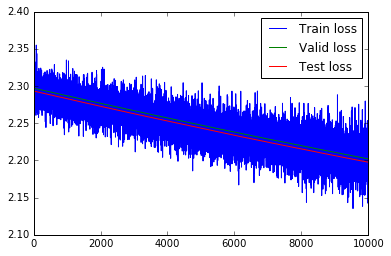

In [6]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

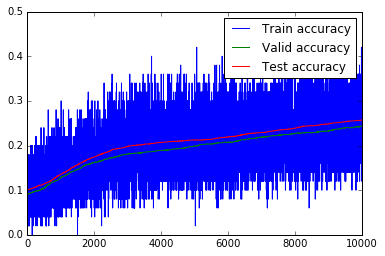

In [7]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()